In [2]:
import pysam

def analyze_reads(bam_file_path, min_length, min_mapq, clip_len):
    """
    Opens a BAM file, filters reads by length and MAPQ, and extracts
    the specified number of 5' soft-clipped bases.
    """
    
    clipped_sequences_counts = {}
    total_reads_processed = 0
    reads_passing_filters = 0

    try:
        with pysam.AlignmentFile(bam_file_path, "rb") as bamfile:
            for read in bamfile:
                total_reads_processed += 1
                if read.query_length <= min_length:
                    continue
                if read.mapping_quality < min_mapq:
                    continue
                if read.is_unmapped or read.is_secondary or read.is_supplementary or read.is_duplicate:
                    continue
                reads_passing_filters += 1

                # Look at the n nucleotides added at the 5' side
                # This refers to soft-clipping (S) at the start of the read.
                
                # The CIGAR string is a list of (operation, length) tuples.
                # CIGAR operation 4 (pysam.CSOFT_CLIP) is for Soft-clipping (S).
                    
                # The 5' soft-clip is the first element of the CIGAR list.
                if read.cigar and read.cigar[0][0] == pysam.CSOFT_CLIP:
                    # 1. Get the TOTAL length of the 5' soft-clip (e.g., 10bp)
                    soft_clip_length = read.cigar[0][1]
                    
                    if soft_clip_length >= clip_len:
                        
                        # 2. The entire 5' soft-clipped sequence is the first 'soft_clip_length' bases
                        #    of the read. We extract this entire segment first.
                        entire_soft_clip = read.query_sequence[:soft_clip_length]
                        
                        # 3. Now, we extract the LAST 'clip_len' bases from this segment.
                        #    If entire_soft_clip is 'ACTGGCATGC' (10bp) and clip_len is 3, 
                        #    this slice gets the last 3 bases: 'TGC'
                        soft_clipped_sequence = entire_soft_clip[-clip_len:]
                        
                        # Store the count of the extracted sequence
                        clipped_sequences_counts[soft_clipped_sequence] = \
                            clipped_sequences_counts.get(soft_clipped_sequence, 0) + 1
                        
    except FileNotFoundError:
        print(f"Error: BAM file not found at {bam_file_path}")
        return

    # --- Results Summary ---
    print(f"--- Analysis Complete ---")
    print(f"Total reads processed: {total_reads_processed}")
    print(f"Reads passing all filters: {reads_passing_filters}")
    print(f"Reads with a 5' soft-clip of at least {clip_len}bp: {len(clipped_sequences_counts)}")
    
    # Sort and print the results
    sorted_counts = sorted(
        clipped_sequences_counts.items(), 
        key=lambda item: item[1], 
        reverse=True
    )
    
    # Present the results in a table for clarity
    print(f"| 5' Sequence | Count | Frequency (%) |")
    print(f"|:---|---:|---:|")
    
    total_clipped = sum(clipped_sequences_counts.values())
    if total_clipped > 0:
        for seq, count in sorted_counts:
            frequency = (count / total_clipped) * 100
            if frequency > 0.5:
                print(f"| **{seq}** | {count} | {frequency:.2f}% |")
    else:
        print("| No soft-clipped sequences found in the filtered reads. | | |")

    return sorted_counts


In [3]:
BAM_FILES = [f"rsvwithgonly/FBE82653_pass_barcode0{i}_03a1f7c4_9c5a4d8a_0.bam" for i in range(1,6)]
MIN_READ_LENGTH = 2000
MIN_MAPPING_QUALITY = 60 
SOFT_CLIP_LENGTH_TO_EXTRACT = 3
sorted_counts = []
# Execute the function
for bam_file in BAM_FILES:
    res = analyze_reads(bam_file, MIN_READ_LENGTH, MIN_MAPPING_QUALITY, SOFT_CLIP_LENGTH_TO_EXTRACT)
    sorted_counts.append(res)

Error: BAM file not found at rsvwithgonly/FBE82653_pass_barcode01_03a1f7c4_9c5a4d8a_0.bam
Error: BAM file not found at rsvwithgonly/FBE82653_pass_barcode02_03a1f7c4_9c5a4d8a_0.bam
Error: BAM file not found at rsvwithgonly/FBE82653_pass_barcode03_03a1f7c4_9c5a4d8a_0.bam
Error: BAM file not found at rsvwithgonly/FBE82653_pass_barcode04_03a1f7c4_9c5a4d8a_0.bam
Error: BAM file not found at rsvwithgonly/FBE82653_pass_barcode05_03a1f7c4_9c5a4d8a_0.bam


[E::hts_open_format] Failed to open file "rsvwithgonly/FBE82653_pass_barcode01_03a1f7c4_9c5a4d8a_0.bam" : No such file or directory
[E::hts_open_format] Failed to open file "rsvwithgonly/FBE82653_pass_barcode02_03a1f7c4_9c5a4d8a_0.bam" : No such file or directory
[E::hts_open_format] Failed to open file "rsvwithgonly/FBE82653_pass_barcode03_03a1f7c4_9c5a4d8a_0.bam" : No such file or directory
[E::hts_open_format] Failed to open file "rsvwithgonly/FBE82653_pass_barcode04_03a1f7c4_9c5a4d8a_0.bam" : No such file or directory
[E::hts_open_format] Failed to open file "rsvwithgonly/FBE82653_pass_barcode05_03a1f7c4_9c5a4d8a_0.bam" : No such file or directory


In [4]:
Glastprop = []
Alastlastprop = []
Glastlastprop = []
isA = []
for i in range(5):
    print(sorted_counts[i][:5])
    all = sum( [s[1] for s in sorted_counts[i]] )
    Glast = sum( [s[1] for s in sorted_counts[i] if s[0][1] == "G"] )
    Alastlast = sum( [s[1] for s in sorted_counts[i] if s[0][0] == "A"] )
    Glastlast = sum( [s[1] for s in sorted_counts[i] if s[0][0] == "G"] )
    Glastprop.append(Glast /all)
    print(Glast/all)
    Alastlastprop.append(Alastlast / all)
    print(Alastlast/all)
    Glastlastprop.append(Glastlast/all)
    print(Glastlast/all)
    isA.append(sum( [s[1] for s in sorted_counts[i] if "A" in s[0]] )/ all)


TypeError: 'NoneType' object is not subscriptable

In [ ]:
Glastprop
68.5+12.24+6.4+5.33

92.47

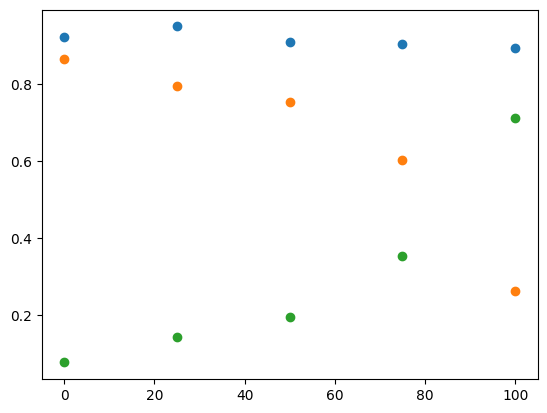

In [ ]:
import  matplotlib.pyplot as plt

x = [100, 75, 50, 25, 0]
# y = [3160/(3160+928), 4615/(4615+7613), 2330/(2330+9262), 59/(59+287), 770/(10869+770)]

plt.scatter(x, Glastprop)
plt.scatter(x, Glastlastprop)
plt.scatter(x, Alastlastprop)

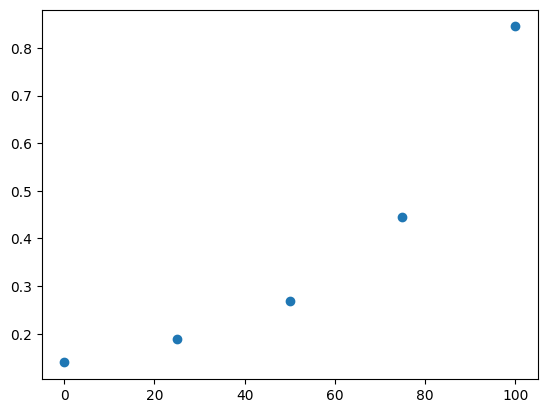

In [ ]:
import numpy as np
plt.scatter(x, isA)

In [ ]:
pc =0.25
puc = 1.0

nc = [0.9*x for x in [0, 25, 50, 75, 100]]
nuc = [100 - x for x in nc]

res = [100*nc[i]*pc/(nc[i]*pc + nuc[i]*puc) for i in range(len(nc))]

plt.plot(nc, res, label = "Theoretical")
plt.scatter(x, 100*(np.array(isA) - isA[-1])/(isA[0]-isA[-1]), label = "Measured", c = "red")
plt.xlabel("Percentage of capped molecules")
plt.ylabel("Percentage of A")
plt.legend()

NameError: name 'plt' is not defined